In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from pyFTS.benchmarks import ResidualAnalysis, Measures

from scipy import stats
from scipy.special import boxcox, inv_boxcox

import os
from numpy.fft import fft, ifft


from itertools import product

import warnings
warnings.filterwarnings('ignore')

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## Mac
os.chdir("/Users/cseveriano/spatio-temporal-forecasting/")

## Windows
#os.chdir("C:\\Users\\cseve\\Google Drive\\Doutorado\\Codes\\spatio-temporal-forecasting")
#sys.path.append('C:\\Users\\cseve\\Google Drive\\Doutorado\\Codes\\spatio-temporal-forecasting\\src\\ext-libraries\\pyFTS')

################################

fln_df = pd.read_csv('data/processed/SONDA/FLN-15min.csv', sep=";", parse_dates=['date'], index_col='date')
fln_df = fln_df[(fln_df.index >= '2013-11-01') & (fln_df.index <= '2015-11-01')]
fln_df = fln_df.fillna(method='ffill')

In [3]:
fln_df = fln_df.resample('H').mean()

In [4]:
def remove_periodic(X, df_index, detrending=True):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    frequency_threshold = 0.1e12
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    
    return rad - rad_clean_ts.values, rad_clean_ts.values

In [5]:
fln_residual, fln_clean = remove_periodic(fln_df['glo_avg'],fln_df.index)

In [6]:
fln_df = pd.DataFrame(data={'glo_avg': fln_df.glo_avg.tolist(), 'residual': fln_residual, 'clean': fln_clean, 'date' : fln_df.index}, index=fln_df.index)

In [7]:
fln_train = fln_df[(fln_df.index >= '2013-11-01') & (fln_df.index <= '2014-10-31')]
fln_test = fln_df[(fln_df.index >= '2014-11-01') & (fln_df.index <= '2015-10-31')]

In [8]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

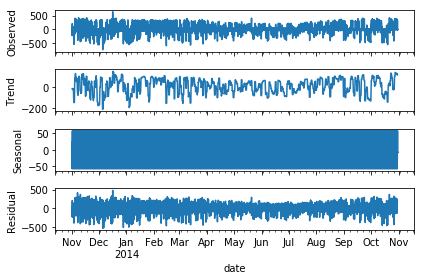

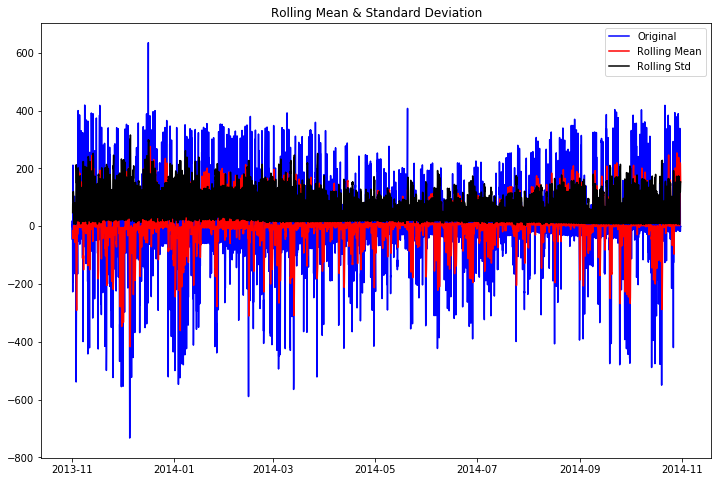

Results of Dickey-Fuller Test:
Test Statistic                -1.232681e+01
p-value                        6.561013e-23
#Lags Used                     2.700000e+01
Number of Observations Used    8.709000e+03
Critical Value (1%)           -3.431101e+00
Critical Value (5%)           -2.861872e+00
Critical Value (10%)          -2.566947e+00
dtype: float64


In [9]:
train_data = fln_df[(fln_df.index >= '2013-11-01') & (fln_df.index <= '2014-10-31')].residual
seasonal_decompose(train_data).plot()
test_stationarity(train_data)
plt.show()

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 6)
Ps = range(0, 3)
ps = range(0, 6)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(train_data, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0, 0, 0)


In [12]:
model = SARIMAX(train_data, order=(3, 1, 1), seasonal_order=(1, 1, 1, 24)).fit()

In [32]:
dta = sm.datasets.macrodata.load_pandas().data
dta.index = pd.date_range(start='1959-01-01', end='2009-07-01', freq='QS')


training_mod = SARIMAX(train_data, order=(6, 1, 1), seasonal_order=(1, 1, 1, 24))
training_res = training_mod.fit()

whole_data = fln_df.residual
test_data = fln_test.residual

mod = SARIMAX(whole_data, order=(6, 1, 1), seasonal_order=(1, 1, 1, 24))
res = mod.filter(training_res.params)

insample = res.predict()
T = len(test_data)

In [37]:
del training_mod
del training_res

In [33]:
fcst = insample[fln_test.index[0] : fln_test.index[-1]].values

In [34]:
fcst =  [sum(x) for x in zip(fcst, fln_test.clean.tolist())]

In [35]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100

In [36]:
_nrmse = normalized_rmse(fln_test.glo_avg.tolist(), fcst)
print("nRMSE: ", _nrmse, "\n")

nRMSE:  44.426803645 

